## Set Up

In [3]:
import pandas as pd
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from queue import PriorityQueue
import math
import random

In [4]:
df = pd.read_csv('tubedata.csv', header=None)
df.head(2)

,0,1,2,3,4,5
0,Harrow & Wealdstone,Kenton,Bakerloo,3,5,0
1,Kenton,South Kenton,Bakerloo,2,4,0


The following code is taken from the Assignment Specifications.

I have added line information to the station list so that the line connecting two stations is inlcuded along with the weight. I orignally intended to include line details in anticipation of 2.3, but found that it was needed in 2.1 as well.

I also edited the zone dictionary so that it is created in two stages. My hueristic depends on calculating the minimum cost between any given pair of zones. This involves

### Dictionary Preperation

Method provided by assignment

In [5]:
station_dict = defaultdict(list)
zone_dict = defaultdict(set)

# get data row by row
for index, row in df.iterrows():
    start_station = row[0]
    end_station = row[1]
    line = row[2]
    
    act_cost = int(row[3])

    zone1 = row[4]
    zone2 = row[5]

    # station dictionary of child station tuples (child_name, line_name, cost from parent to the child)
    # {"Mile End": [("Stepney Green", "District", 2), ("Wembley", "Hammersmith & City",  1)]}
    station_list = station_dict[start_station]
    station_list.append((end_station, act_cost, line))

    # the following two lines add the other direction of the tube "step"
    station_list = station_dict[end_station]
    station_list.append((start_station, act_cost, line))

   # we add the main zone
    zone_dict[start_station].add(zone1)
    # we add the secondary zone
    if zone2 != "0":
        zone_dict[start_station].add(zone2)
    # if the secondary zone is not 0 it's the main zone for the ending station
        zone_dict[end_station].add(zone2)
    else:
    # otherwise the main zone for the ending station is the same as for the starting station
        zone_dict[end_station].add(zone1)

The given method for constructing the zone data results in some strange cases. The example below show cases a station that is located in three zones. 

Considering that zones are radial and where gants hill is located on the current zone map, I believe this a product of the use of the secondary and primary zones to fill in zone details in tube data. As described on the forum, some stations don't have a connection between stations where they are listed as the starting station.To improve the hueristic in 2.4, I will take a slightly different approach to the zone data dictionary. The reasoning for going through these steps will be apparent once the hueristic is constructed

In [6]:
zone_dict['Gants Hill']

{'4', '5', '6'}

To improve the hueristic in 2.4, I will take a slightly different approach to the zone data dictionary. The reasoning for going through these steps will be apparent once the hueristic is constructed

The new zone dictionary is a dictionary of dictionaries. The outer key corresponds is the station names and each element is a dictionary with two keys and elements descriebd:
- **main_zones**: the set of zones a station is located in
- **connected_zones**: the set of zones of the stations that the station is connected to

The goal is to store the zone(s) each station along with all of the zones you can reach from that station in one step

In [7]:
zone_dict_enh = {}

#first iterate through adding primary and seconday zones of the starting stations listed in the dictionary
for index, row in df.iterrows():
    start_station = row[0]
    end_station = row[1]
    
    act_cost = int(row[3])

    zone1 = row[4]
    zone2 = row[5]

    #add start station to dictionary if not already there
    if start_station not in zone_dict_enh:
        zone_dict_enh[start_station] = {'main_zones': set(), 'connected_zones': set()}

    #add end station to dic if not already there
    if end_station not in zone_dict_enh:
        zone_dict_enh[end_station] = {'main_zones': set(), 'connected_zones': set()}
    

    #zone1 is the main zone of the start station
    zone_dict_enh[start_station]['main_zones'].add(zone1)

    #the ending station is connected to the primary zone of the start station
    zone_dict_enh[end_station]['connected_zones'].add(zone1)

    #If the secondary station != 0 the start station is also located in the secondary zone 
    #The end station is therefore connected to the second zone
    if zone2 != '0':
        zone_dict_enh[start_station]['main_zones'].add(zone2)
        zone_dict_enh[end_station]['connected_zones'].add(zone2)

    

We now address the cases where no zone data is available for an ending station. These are the cases that justified the original construction of the zone dictionary provided in the assignment. so 

I use the suggested technique of using the primary and secondary stations to determine their zone 
- if the secondary zone is zero, use the primary zone of starting station. If the secondary zone is not equal to zero, use the secondary zone

In [8]:
for index, row in df.iterrows():
    start_station = row[0]
    end_station = row[1]

    zone1 = row[4]
    zone2 = row[5]
    #no zone location available for end station
    if len(zone_dict_enh[end_station]['main_zones']) == 0:
        #if secondary zone is not zero, use secondary zone
        if zone2 != '0':
            zone_dict_enh[end_station]['main_zones'].add(zone2)
        #otherwise use primary zone
        else:
            zone_dict_enh[end_station]['main_zones'].add(zone1)
        

In [9]:
for station in zone_dict_enh:
    if len(zone_dict_enh[station]['main_zones']) < 1:
        print('issue with { }'.format(end_station))

Now that the set of main zones is complete, we iterate back through the dataframe again. The goal is to make sure that 
- All main zones of the starting station are in the connected zones of the ending station
- All main zones of the end station are in the connected zones of the starting station

In [10]:
for index, row in df.iterrows():
    start_station = row[0]
    end_station = row[1]

    zone1 = row[4]
    zone2 = row[5]

    start_main = zone_dict_enh[start_station]['main_zones']
    end_main = zone_dict_enh[end_station]['main_zones']
    
    zone_dict_enh[start_station]['connected_zones'].update(zone_dict_enh[end_station]['main_zones'])
    zone_dict_enh[end_station]['connected_zones'].update(zone_dict_enh[start_station]['main_zones'])

Note how the record for the example below has changed

In [11]:
zone_dict_enh['Gants Hill']

{'main_zones': {'5', '6'}, 'connected_zones': {'4'}}

The final step to prepare for the heuristic is the construction of a minimum path cost dictionary. The goal is to use our data to calculate the minimum path cost to travel from one zone to another

We iterate through the data looking at each connection between stations. 

In [12]:
min_time_dict = {}
for index, row in df.iterrows():
    start_station = row[0]
    end_station = row[1]
    time = row[3]

    start_zones = zone_dict_enh[start_station]['main_zones']
    end_zones = zone_dict_enh[end_station]['main_zones']

    #for each connection in our data, look at each combination of zones of the start station and zones of the end station
    for s_zone in start_zones:
        for e_zone in end_zones:
            #Create or update record in min_time_dict
            #where the key = 'starting zone - ending zone'
            #value is equal to the minimum path cost between the starting zone and the ending zone
            key1 = s_zone + '-' + e_zone
            key2 = str(e_zone) + '-' + s_zone
            if key1 not in min_time_dict:
                min_time_dict[key1] = time
            else:
                if time < min_time_dict[key1]:
                    min_time_dict[key1] = time
            #Repeat for inverted keys
            #key = 'ending zone - starting zone'
            if key2 not in min_time_dict:
                min_time_dict[key2] = time
            else:
                if time < min_time_dict[key2]:
                    min_time_dict[key2] = time
            

The result is a dictionary of all the minimums of existing transitions within and between zones.

For example, the output below is the minimum average time when traveling from a station in zone 5 to a station in zone 4

In [13]:
print(min_time_dict['5-4'])

2


### Graph Construction

I construct a graph representation of the tube system using the MultiDiGraph object in the NetworkX package. All code is based on the references provided in the networkX documentation.

Each node represents a station and each edge represents tube connection between stations on a specific line. The weights of each edge are the average travel time between the two stations on that line. 

My reasoning for using the MultiDiGraph object was that it allows for multiple edges between nodes. There are cases in the dataset where multiple lines run between two stations. In a handful of cases these lines can have different weights associated with edges between them.

In [14]:
tube_graph_multi = nx.MultiDiGraph()

for station in station_dict:
    if not tube_graph_multi.has_node(station):
        tube_graph_multi.add_node(station)
    for neighbor in station_dict[station]: 
        neighbor_station = neighbor[0] 
        neighbor_weight = neighbor[1] 
        neighbor_line = neighbor[2]
        if not tube_graph_multi.has_node(neighbor_station):
            #print('adding neighbor {}'.format(neighbor_station))
            tube_graph_multi.add_node(neighbor[0])
        if not tube_graph_multi.has_edge(station, neighbor_station, key = neighbor_line):
            tube_graph_multi.add_edge(station, neighbor_station, weight = neighbor_weight, key=neighbor_line)

The example below is used as a justification for the use of a multi edge graph.

The cell displays the different lines connecting paddington to edgware in the original dataframe. Note that the journey is one minute longer on hammersmith and city than the other three lines that connect the two

In [15]:
df[((df[0] == 'Paddington')| (df[0] == 'Edgware Road'))&((df[1] == 'Paddington')| (df[1] == 'Edgware Road'))]

,0,1,2,3,4,5
13,Paddington,Edgware Road,Bakerloo,3,1,0
73,Paddington,Edgware Road,Circle,3,1,0
113,Edgware Road,Paddington,District,3,1,0
176,Paddington,Edgware Road,Hammersmith & City,4,1,0


Given that these cases exist, single edged graphs wouldn't be capable of producing accurate time estimates based on the data that's provided. We would need to choose one of the two weights to represent the edges called out above when constructing the graph.

As I will explain in my comments later, including all of the edges is not needed in the implementation of DFS, BFS, and UCS. In all cases, we could simply choose one of the fastest edges between two stations when constructing the graph to improve efficiency on execution. The different costs of the lines will become relevant once we update the cost function of UCS in 2.3 so I have decided to keep the graph structure consistent across the assignment

### Graph Plot

Plot is largely unhelpful, but used as a general sanity check for the construction of the graph

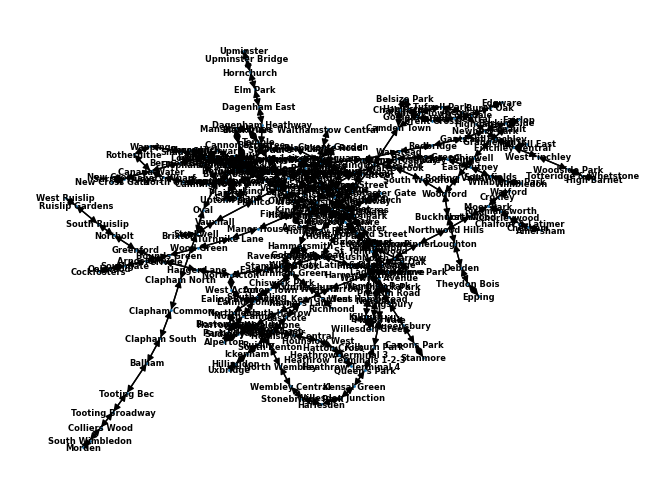

In [16]:
nx.draw(tube_graph_multi, with_labels=True, node_size=1, font_weight='bold', font_size = 6)

## DFS, BFS, and UCS

### DFS

The original code originates from lab 2. I have commented to show understanding and modified it in two key ways to adapt to the problem

- I have added edge weights to the state representation so that the final path cost can be computed and compared in following sections
- I have added a section of code that handles multiple edges between the current node and the child

I considered two approaches to the latter.
- Add a record to the frontier for each edge that connects a parent to an unexplored child
- Add only a single entry to frontier corresponding to one of the edges that connects a parent to an unexplored child

The former method results in multiple entries in the frontier for every node that has multiple edges connecting it to its parent. The path including the edge that's explored last would be the first opened from the set. Also, the exploration check would consider not only the child node, but the particular sequence of edges taken to reach the child. 

One could argue that this is a better representation for DFS of a multi-edge graph, but this would decrease the speed of the algorithm as it now visits some stations multiple times.

Considering the goal of this implementation is to produce a path from a initial state to the goal state, I decided to go with the latter. Whenever there are multiple edges connecting a parent to a child, I iterate through the edges and choose one of the lines with the lowest edge weight. I should note that the speed of the algorithm could be improved by selecting a random edge without iterating through them. 

The argument for this approach is that it produces results close to identical to DFS performed on a single edge graph where each edge between two nodes is one of the lines that minimizes cost between the two stations. Equivalence between my implementation and the single edge graph approach assumes the same method for selecting edges that minimize cost. 

Overall, I argue that this is context specific optimization that maintains the rules of a DFS algorithm while keeping the structure of the graph consistent across the assignment.

#### State Definition

Each state is represented by:
$$state_x = (n_i, s_{x-1}, l_q, c_r )$$

Where,
- $n_i$ is the current station (current node)
- $s_{x-1}$ is the preceding state on the current path
- $l_q$ is the line taken to get to station $n_i$ from $n_j$ in $s_{x-1}$ (preceeding station on current path)
- $c_r$ is the cost to get to the $n_i$ from $n_j$ on the line $l_q$
    - (cost is the average time to get from parent station to current station)


#### Implementation

In [17]:
#constructs path for both DFS and BFS outputs
#returns a list with the path from the origin to the destination 
#and the summation of the edge weights along the path (total time in solution)
#if return_lines=True, then returns a list of tuples representing the path taken in the format: (station, line_taken_to_station)
#if return_lines=False, then returns a list of stations in the format: 
def construct_path(node, return_lines=False):
    path_from_root = []
    total_time = 0
    #The solution from both the bfs and dfs function return a dictionary of the format
    #{label: 'example_node', weight: weight_from_parent, line: line_from_parent, parent: parent_node}
    #where parent_node is a dictionary of the same format of the node that preceeded example_node
    while node['parent']:
        if return_lines:
            path_from_root.insert(0,(node['label'],node['line']))
        else:
            path_from_root.insert(0,node['label'])
        total_time += node['weight_from_parent']
        node = node['parent']
    if return_lines:
        path_from_root.insert(0,(node['label'],''))
    else:
        path_from_root.insert(0,node['label'])
    return path_from_root, total_time

In [18]:
#returns a dictionary with path and weight details and the count of the total number of nodes visited

def dfs(graph, initial, goal, print_exploration_cost=False, reverse=False):
    #initialize the frontier with the origin
    #For each node in the frontier, we track the name of the node is avg time from the parent to the node, 
    #and the parent state
    #each of these dictionaries represents a State
    
    frontier = [{'label':initial, 'weight_from_parent':0, 'line':None, 'parent':None}]
    explored = {initial}
    number_of_explored_nodes = 0
    
    #While there are nodes that have not been explored
    while frontier:
        #We start by popping the last node in the frontier (LIFO, most recently added)
        current_node = frontier.pop()
        current_node_label = current_node['label']
        #mark that we have visited the current node
        explored.add(current_node_label)
        number_of_explored_nodes +=1
        
        #check to see if the current node satisfies objective
        #Goal test could be performed when checking children to improve speed
        #I kept it in this section of the script for cleanliness
        if current_node_label == goal:
            if print_exploration_cost:
                print('Nodes visited {}'.format(number_of_explored_nodes))
            return current_node, number_of_explored_nodes
    
        #reverse parameter is maintained from prior lab for Q2.2
        if reverse:
            neighbors = reversed(list(graph.neighbors(current_node_label)))
        else:
            neighbors = list(graph.neighbors(current_node_label))
        
        #we check all children of the current node
        #if they haven't been explored yet, we add a new node to the end of the frontier for each child.
        #note that the parent information contains the weights and parents for all prior steps in the path
        #this is converted into a tuple with the total weight and a list of the path from start to end in the
        #construct_path function
        for child in neighbors:
            if child not in explored:
                #To avoid creating a record on the frontier for each line from the current node to the child I do the following:
                #weight is irrelevant to the way DFS sorts nodes so I will only add one record to frontier corresponding
                #to a line that minimizes the cost from the current node to the child
                #this removes the case where the algorithm revisits the same node for every edge that connects its parent to it
                lines = graph.get_edge_data(current_node_label, child)
                edge_costs = []
                for line in lines:
                    weight = lines[line]['weight']
                    edge_costs.append((weight, line))
                fastest_line =  min(edge_costs)   
                frontier.append({'label':child, 'weight_from_parent':fastest_line[0] ,'line':fastest_line[1], 'parent':current_node})
    return None, None

#### DFS summary function

Input: start location, end location, reverse = Bool, display_line = Bool

The first three inputs are self explantory, return_lines=True provides the lines taken from one station to another in the solution output.

If display_lines = False
- output format: [intial station, station 2, ..., goal station]

If display_lines = True
- output format: [(intial station,''), (station 1,line_1), ..., (goal station,line_n)]
- Where line_i is the line taken from station i-1 to station i

In [19]:
def run_dfs(start, end, reverse=False, return_lines=False):
    dfs_path, node_count = dfs(tube_graph_multi, start, end, False, reverse)
    solution, total_time_dfs = construct_path(dfs_path, return_lines)
    print('Path from start to end with station and line taken')
    print(solution)
    print('Average Time for Route: {}'.format(total_time_dfs))
    print('Number of Nodes Visited: {}'.format(node_count))
    return solution

In [20]:
solution = run_dfs('Euston','Victoria', return_lines=False)

Path from start to end with station and line taken
['Euston', "King's Cross St. Pancras", 'Russell Square', 'Holborn', 'Covent Garden', 'Leicester Square', 'Piccadilly Circus', 'Green Park', 'Victoria']
Average Time for Route: 13
Number of Nodes Visited: 26


### BFS

Again this is based off of code from lab 2. I have commented and modified it in a similar way to the past example.

To avoid being overly verbose, BFS was modified in the same way as DFS was modified. Edge weights from parent to a node are stored in the state and only one of the fastest edges between two nodes is considered when adding to the frontier.

The justification for using this method is the same as it was in DFS. This approach maintains consistency of the graph structure across the assignment while removing the need to explore the same nodes multiple times. In this case, my implementation mimics BFS performed on a single edge graph where the edge selected is one of the edges that minimizes the cost

#### State Definition

The State definition is the same as it was in DFS

#### Implementation

In [21]:
def bfs(graph, initial, goal, print_exploration_cost=False, reverse=False):

    #Similar to DFS, we use the same format to represent nodes on the frontier
    #We use the construct_path function to create the solution list and compute total cost
    number_of_explored_nodes = 0
    frontier = [{'label':initial,'weight_from_parent': 0, 'line':None, 'parent':None}]
    frontier_labels = [initial]
    explored = {initial}

    while frontier:
        #With BFS we pop the first element of our frontier so that we search first element that was added
        #in our current list (FIFO)
        current_node = frontier.pop(0)
        current_node_label = current_node['label']
        frontier_labels.remove(current_node_label)
        weight = current_node['weight_from_parent']
        line = current_node['line']
        explored.add(current_node_label)
        number_of_explored_nodes += 1
        
        #after incrementing our node count, perform goal check
        #like DFS, Goal check could be performed while checking children 
        if current_node_label == goal:
            if print_exploration_cost:
                print('bfs graph search explored {} node'.format(number_of_explored_nodes))
            return {'label':current_node_label,'weight_from_parent': weight, 'line':line,  'parent':current_node['parent']}, number_of_explored_nodes
        
        if reverse:
            neighbors = reversed(list(graph.neighbors(current_node_label)))
        else:
            neighbors = list(graph.neighbors(current_node_label))
        
        for child in neighbors:
            if child not in explored and child not in frontier_labels:
                #like dfs, path cost is irrelevant to the solution that is found
                #I perform a similar solution to DFS to avoid the case where a node on the frontier gets visited multiple times
                #due to multiple edges connecting it to its parent
                #take the minimum weighted line and append that path to the frontier
                lines = graph.get_edge_data(current_node_label, child)
                edge_costs = []
                for line in lines:
                    weight = lines[line]['weight']
                    edge_costs.append((weight, line))
                fastest_line =  min(edge_costs) 
                frontier.append({'label':child, 'weight_from_parent': fastest_line[0], 'line':fastest_line[1] ,'parent':current_node})
                frontier_labels.append(child)
                
    return None, None

#### BFS summary function

Input: start location, end location, reverse = Bool, return_line = Bool

This function is the same as run_dfs(), but bfs is ran instead

In [22]:
def run_bfs(start, end, reverse=False, return_line=False):
    bfs_path, node_count = bfs(tube_graph_multi, start, end, False, reverse)
    solution, total_time_bfs = construct_path(bfs_path, return_line)
    print('Path from start to end with station and line taken')
    print(solution)
    print('Average Time for Route: {}'.format(total_time_bfs))
    print('Number of Nodes Visited: {}'.format(node_count))
    return solution

In [23]:
solution = run_bfs('Euston', 'Victoria', return_line=False)

Path from start to end with station and line taken
['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
Average Time for Route: 7
Number of Nodes Visited: 35


### UCS

BFS is the special case of UCS where the weight of each edge is 1. I defined the cost function as the cumulative sum of the average time associated with each step on the graph. 

In this case I use a priority queue for the frontier. UCS expands nodes based on the cost function so I expect that the reverse parameter would only have an effect on solution if there are two potential paths with the same cost. Nodes will be expanded in order of their priority regardless of their arrangement in relation to parent. In this case ordering depends on the order that paths with equal cost were inserted into the queue.

I applied a similar technique to optimize the algorithm as in BFS and DFS. If there are two or more lines connecting a station to an unexplored node, we would need to add multiple records to the frontier for each edge connecting the two. Considering that UCS orders the frontier based on the cumulative weight of a path to a node, the algorithm will always prioritize solutions that take faster lines. There is no penalty for switching stations at this stage, so once again, an edge (line) that minimizes the cost between two stations is selected when this case is presented. One record is added to the frontier representing the path to the child that takes this line.

#### State Definition

The state definition for this implementation of contains the similar information to BFS and DFS, however the data is formatted differently and individual path weights are not stored. I will rewrite the state representation below to provide clarity.

$$state_x = (c_x, i_q, p_x)$$

Where,
- $p_x$ represents the path with elements
    - Each element $sl_i$ is a tuple in the format $(s_i,l_i)$ where
        - $s_i$ is the ith station on the path
        - $l_i$ is the line corresponding to the edge that connects $s_{i-1}$ and $s_{i}$
    - The station in the first element of $p_x$ is the root node
    - the station in the last element of $p_x$ is the current node
- $c_x$ is the total sum of the cost (average time) in the path described by $p_x$
- $i_q$ is a unique number to the state. If two paths with equal cost are considered, the one with the lower i will be selected first

This state definition differs from the prior state definition in that it doesn't track the individual cost associated with the movement from a station $s_i$ to $s_i+1$. Instead, it only includes the cumulative cost. 

Although formatted differently, the state definition of BFS and DFS contains the information needed to produce the path to the current node as well as the cumulative weight of the path. All details necessary to produce this are defined in parent states.

I justify using a different format for the data in this algorithm because the updated UCS cost function in 2.3 will require each state to contain an assembled path to compute the cost.

#### Implementation

In [24]:
def ucs(graph, initial, goal, print_exploration_cost=False, reverse=False):

    number_of_explored_nodes = 0
    #with UCS we use a priority queue based on the cumulative weight of a path to a given node
    #queue.priorityqueue doesn't have built in methods to update paths/path costs if a better route a child is found
    #functionally, adding multiple paths to the same child wouldn't effect optimality because 
    #the better path will always be explored first, however updating items in the priority queue can decrease the number
    #of nodes that are explored. if you find two paths to a node, the better path will get explored first, but the old path
    #will remain in the queue. Depending on the case, the worse path may still get opened
    #I use a workaround involving a separate dictionary that keeps a reference to the item inserted
    #into the priority queue to achieve this effect
    
    frontier = PriorityQueue()
    frontier_records = {}
    #Frontier is filled with lists
    #the first element is the cost of reaching a given node in a particular path from the start station
    #the second element is a unique number assigned to a particular path. This is used to preserve a order
    #when states have equal costs
    #The third element is the path where The first term is the weight of the path to the current node, 
    #the second term is the path each element of the path is a tuple with the location, and the line taken to get there
    #ex:(2, 123, [('initial station', '')('station name', 'line name')])
    
    #frontier labels is a  dictionary that stores references to the items inserted in the priority queue
    #the key is the name of the station and the value is the list
    #lists are used in both the priority queue and the dictionary because they are mutable
    #if the algorithm finds a better path to a node, the old cost is updated to an arbitrarily large number 
    #and a new cost and list is inserted
    #More details on this later, but the data structures used to implement priority queues
    #aren't designed to handle changing values once they have been inserted hence some of the workarounds
    #the use of priority queue was based on the UCS pseudocode provided in the Russell/Norvig Text
    
    initial_record = [0, 0, [(initial, '')]]
    frontier_records[initial] = initial_record
    
    frontier.put(initial_record)
    explored = {initial}
    #used to generate unique integer indicating order that state was reached
    iterations = 0 
    
    #used to mark queue entries for removal
    remove_num = 10000000000
    while frontier:
        
        frontier_list = frontier.get()
        current_path = frontier_list[2].copy()
        #index is to grab the station name from most recent item in the path
        current_node = current_path[-1][0]
        current_path_weight = frontier_list[0]
        #we remove the reference record from the frontier and mark the node as explored
        _ = frontier_records.pop(current_node)
        explored.add(current_node)
        number_of_explored_nodes += 1
        
        #unlike dfs and bfs, goal test for ucs must be done after the nodes have been added to priority queue
        #in BFS and DFS we can halt the search when we reach the goal state in the child
        #for UCS to be optimal, we need to to add the children to the priority queue based on the 
        #cumulative weight in the path
        #even if the goal is found when searching children, its possible the final step to the goal is of high enough weight 
        #that there is a solution with lower cost
        if current_node == goal:
            if print_exploration_cost:
                print('UCS graph search explored {} nodes'.format(number_of_explored_nodes))
            return current_path, number_of_explored_nodes, current_path_weight
        
        if reverse:
            neighbors = reversed(list(graph.neighbors(current_node)))
        else:
            neighbors = list(graph.neighbors(current_node))
            
        for child in neighbors:
            #while path cost is relevant to UCS, in this case we will always prefer an edge with a lower weight than the other edge
            #like bfs and dfs, iterate through edges connecting current node to child
            #we select the line with the lowest weight and use that edge to continue the path

            #This step is perfomed before the check because the full cost/path is prior to checking the frontier
            iterations += 1
            lines = graph.get_edge_data(current_node, child)
            edge_costs = []
            for line in lines:
                weight = lines[line]['weight']
                edge_costs.append((weight, line))
            fastest_line =  min(edge_costs)
            path_to_child = current_path.copy()
            path_to_child.append((child, fastest_line[1]))
            #Cost function: total cost to current point + the cost to the child
            path_weight_to_child = current_path_weight + fastest_line[0]
            child_record = [path_weight_to_child, iterations,  path_to_child]

            #if child has not been explored or added to the frontier
            if child not in explored and child not in frontier_records.keys():
                frontier_records[child] = child_record
                frontier.put(child_record)
                
                
            #child is in frontier and the path cost is worse than what was found
            elif child in frontier_records.keys() and frontier_records[child][0] > path_weight_to_child:
                
                #arbitrarily large number used to move old record to back of queue. 
                frontier_records[child][0] = remove_num
                
                #dictionary is updated with new reference to queue item
                _ = frontier_records.pop(child) 
                frontier_records[child] = child_record

                #better path to child is inserted into queue with updated cost
                frontier.put(child_record)

                #priority queues are often built using a binary trees, heaps, or linked lists 
                #when the reference value is updated, the pointers within the structure stay the same. 
                #We can get around this by reconstucting the queue to force it to resort

                #its questionable whether the time saved in not exploring the same nodes is worth 
                #the time added by performing this step. I am unsure why russell/norvig specified updating 
                #a priority queue in the UCS psuedocode

                f_copy =PriorityQueue()
                while not frontier.empty():
                    record = frontier.get()
                    if record[0] != remove_num:
                        f_copy.put(record)
                frontier = f_copy

    return None, None, None 

#### UCS summary function

Input: start location, end location, reverse = Bool, return_line = Bool

This function is the same as run_dfs() and run_bfs(), but UCS is ran instead

In [25]:
def run_ucs(start, end, reverse=False ,return_line=False ):
    solution, node_count, total_time_ucs = ucs(tube_graph_multi, start, end, False, reverse)

    #default output solution is list of tuples with station and line
    #converts output to just station
    if not return_line:
        solution = [i[0] for i in solution]
    
    print('Path from start to end with station and line taken')
    print(solution)
    print('Average Time for Route: {}'.format(total_time_ucs))
    print('Number of Nodes Visited: {}'.format(node_count))
    return solution

In [26]:
solution_ucs = run_ucs('Canada Water','Stratford',return_line=True)

Path from start to end with station and line taken
[('Canada Water', ''), ('Rotherhithe', 'East London'), ('Wapping', 'East London'), ('Shadwell', 'East London'), ('Whitechapel', 'East London'), ('Stepney Green', 'District'), ('Mile End', 'District'), ('Stratford', 'Central')]
Average Time for Route: 14
Number of Nodes Visited: 52


## Performance analysis

### Setup

To begin I generate a dataframe that has a wide number of routes. We can then use this data to get an idea of the average number of nodes and the average expectated tube time for the solutions returned by the algorithms.

I will use a combination of the examples provided as well as a few start and end locations that are randomly sampled


The method below was used to create the Examples. I've hardcoded the output in the next cell to avoid issues with replication

In [25]:
routes = ({1: ('Euston','Victoria'), 2: ('Canada Water','Stratford' ), 3: ('New Cross Gate','Stepney Green'),
           4: ('Ealing Broadway','South Kensington' ), 5:('Baker Street','Wembley Park' )})

for i in range(0,95):
    random.seed(i)
    start = random.sample(list(station_dict),1)[0]
    end = random.sample(list(station_dict),1)[0]
    routes[i+6] = (start,end)

In [26]:
routes = ({1: ('Euston', 'Victoria'), 2: ('Canada Water', 'Stratford'), 3: ('New Cross Gate', 'Stepney Green')
           , 4: ('Ealing Broadway', 'South Kensington'), 5: ('Baker Street', 'Wembley Park')
           , 6: ('Archway', 'Kennington'), 7: ('Buckhurst Hill', 'North Acton'), 8: ('Northolt', 'Chancery Lane')
           , 9: ('Plaistow', 'Snaresbrook'), 10: ('West Ham', 'West Hampstead'), 11: ('Hornchurch', 'Watford')
           , 12: ('Lancaster Gate', 'Boston Manor'), 13: ('Canning Town', 'Barbican')
           , 14: ('Whitechapel', 'Mill Hill East'), 15: ('Manor House', 'High Barnet'), 16: ('Baker Street', 'Oval')
           , 17: ('Oakwood', 'Finsbury Park'), 18: ('Russell Square', 'Canada Water'), 19: ('Upminster', 'Queensbury')
           , 20: ('Leytonstone', 'Vauxhall'), 21: ('Olympia', 'Stonebridge Park'), 22: ('Chorleywood', 'Holloway Road')
           , 23: ('Highbury & Islington', 'Warren Street'), 24: ('Bayswater', 'Grange Hill')
           , 25: ('Waterloo', 'Seven Sisters'), 26: ('Barbican', 'Shoreditch'), 27: ('Temple', 'Leicester Square')
           , 28: ('Theydon Bois', 'Barking'), 29: ('Queensbury', 'Marble Arch'), 30: ('Highgate', 'Ealing Common')
           , 31: ('Woodside Park', 'Willesden Junction'), 32: ('Fulham Broadway', "Earls' Court")
           , 33: ('Knightsbridge', 'Goldhawk Road'), 34: ('Gants Hill', 'Snaresbrook')
           , 35: ('Holland Park', 'Ruislip Manor'), 36: ('Queensbury', 'Marylebone'), 37: ('Harlesden', 'Holloway Road')
           , 38: ('Notting Hill Gate', 'Gunnersbury'), 39: ('Westminster', 'Bromley-by-Bow'), 40: ('Brixton', 'Croxley')
           , 41: ('Northwood Hills', 'South Woodford'), 42: ('Harrow-on-the-Hill', 'Greenford')
           , 43: ('Chancery Lane', 'Walthamstow Central'), 44: ('Kennington', 'Oval'), 45: ('Richmond', 'Upminster')
           , 46: ('Bounds Green', 'Pimlico'), 47: ('East Finchley', 'Pinner'), 48: ('Gants Hill', 'Warwick Avenue')
           , 49: ('Piccadilly Circus', 'Stanmore'), 50: ('Chalk Farm', 'Seven Sisters')
           , 51: ('New Cross Gate', 'Goodge Street'), 52: ('Notting Hill Gate', 'Hendon Central')
           , 53: ('Hillingdon', 'North Acton'), 54: ('London Bridge', 'South Woodford'), 55: ('West Acton', 'Eastcote')
           , 56: ('Heathrow Terminal 3', 'Rotherhithe'), 57: ('Barking', 'North Ealing')
           , 58: ('Canada Water', 'South Ruislip'), 59: ('Stamford Brook', 'Arnos Grove'), 60: ('Debden', 'Balham')
           , 61: ('Chancery Lane', 'East Putney'), 62: ('Stonebridge Park', 'Russell Square')
           , 63: ('Embankment', 'Amersham'), 64: ('East Putney', "Earls' Court"), 65: ('West Kensington', 'Bond Street')
           , 66: ('Swiss Cottage', 'Royal Oak'), 67: ('Hatton Cross', 'Ealing Common'), 68: ('Sloane Square', 'Ealing Broadway')
           , 69: ('Colliers Wood', 'Colliers Wood'), 70: ('Covent Garden', 'Chigwell'), 71: ('Warren Street', 'Canons Park')
           , 72: ('White City', 'Green Park'), 73: ('Holland Park', 'Barkingside')
           , 74: ('Finsbury Park', 'Heathrow Terminals 1-2-3'), 75: ('Piccadilly Circus', 'Liverpool Street')
           , 76: ('Fairlop', 'Wembley Park'), 77: ('Canning Town', 'Sudbury Town'), 78: ("Shepherd's Bush", 'Chiswick Park')
           , 79: ('Ladbroke Grove', 'Grange Hill'), 80: ('Walthamstow Central', 'Newbury Park')
           , 81: ('Cockfosters', 'Clapham South'), 82: ('Mill Hill East', 'Manor House'), 83: ('Elm Park', 'Preston Road')
           , 84: ('Turnham Green', 'Liverpool Street'), 85: ('Euston Square', 'Balham'), 86: ('New Cross Gate', 'Edgware')
           , 87: ('Alperton', 'Southgate'), 88: ('Euston Square', 'Hounslow East'), 89: ('Heathrow Terminal 3', 'Wood Green')
           , 90: ('Royal Oak', 'Piccadilly Circus'), 91: ('Parsons Green', 'Leytonstone'), 92: ('Marylebone', 'Bermondsey')
           , 93: ('Euston Square', 'Turnham Green'), 94: ('Colindale', 'Wimbledon'), 95: ('Lancaster Gate', 'Upminster')
           , 96: ('West Brompton', "St. Paul's"), 97: ('Marble Arch', 'Sloane Square'), 98: ('Kennington', 'Blackhorse Road')
           , 99: ('Hatton Cross', 'Hillingdon'), 100: ('Ealing Common', 'Chigwell')})

The following function is used to create a row in the dataframe used in analysis

In [27]:
def compare_search(graph, route_num, start, end):
    
    #dfs
    dfs_path, node_count_dfs = dfs(graph, start, end, False, False)
    solution_dfs, total_time_dfs = construct_path(dfs_path, return_lines=True)
    
    #dfs inverted
    dfs_path_rev, node_count_dfs_rev = dfs(graph, start, end, False, True)
    solution_dfs_rev, total_time_dfs_rev = construct_path(dfs_path_rev, return_lines=True)
    
    #bfs
    bfs_path, node_count_bfs = bfs(graph, start, end, False, False)
    solution_bfs, total_time_bfs = construct_path(bfs_path, return_lines=True)
    
    #bfs_inv
    bfs_path_rev, node_count_bfs_rev = bfs(graph, start, end, False, True)
    solution_bfs_rev, total_time_bfs_rev = construct_path(bfs_path_rev, return_lines=True)
    
    #UCS
    solution_ucs, node_count_ucs, total_time_ucs = ucs(graph, start, end, False, False)
    
    #ucs inv
    solution_ucs_rev, node_count_ucs_rev, total_time_ucs_rev = ucs(graph, start, end, False, True)
    
    results = ([route_num, node_count_dfs, total_time_dfs, solution_dfs,
               node_count_dfs_rev,total_time_dfs_rev, solution_dfs_rev,
               node_count_bfs, total_time_bfs, solution_bfs,
               node_count_bfs_rev, total_time_bfs_rev, solution_bfs_rev,
               node_count_ucs,total_time_ucs,solution_ucs,
               node_count_ucs_rev, total_time_ucs_rev, solution_ucs_rev])
    
    return results
    


Column definitions of the table

In [28]:
summary_table_columns = (['route_num', 'dfs_node_count', 'dfs_solution_time', 'dfs_solution',
                        'dfs_rev_node_count', 'dfs_rev_solution_time','dfs_rev_solution',
                        'bfs_node_count', 'bfs_solution_time', 'bfs_solution',
                        'bfs_rev_node_count', 'bfs_rev_solution_time','bfs_rev_solution',
                        'ucs_node_count', 'ucs_solution_time', 'ucs_solution',
                        'ucs_rev_node_count', 'ucs_rev_solution_time','ucs_rev_solution'])

In [29]:
summary_table = []
for route in routes:
    start_fin = routes[route]
    route_start = start_fin[0]
    route_fin = start_fin[1]
    #print(start_fin)
    results = compare_search(tube_graph_multi,route,route_start,route_fin)
    summary_table.append(results)
    
summary_df = pd.DataFrame(data=summary_table, columns=summary_table_columns)

In [30]:
print(summary_df.shape)
summary_df.head(2)

(100, 19)


,route_num,dfs_node_count,dfs_solution_time,dfs_solution,dfs_rev_node_count,dfs_rev_solution_time,dfs_rev_solution,bfs_node_count,bfs_solution_time,bfs_solution,bfs_rev_node_count,bfs_rev_solution_time,bfs_rev_solution,ucs_node_count,ucs_solution_time,ucs_solution,ucs_rev_node_count,ucs_rev_solution_time,ucs_rev_solution
0,1,26,13,"[(Euston, ), (King's Cross St. Pancras, Northe...",88,69,"[(Euston, ), (Warren Street, Northern), (Goodg...",35,7,"[(Euston, ), (Warren Street, Northern), (Oxfor...",34,7,"[(Euston, ), (Warren Street, Northern), (Oxfor...",30,7,"[(Euston, ), (Warren Street, Northern), (Oxfor...",28,7,"[(Euston, ), (Warren Street, Northern), (Oxfor..."
1,2,6,15,"[(Canada Water, ), (Canary Wharf, Jubilee), (N...",263,24,"[(Canada Water, ), (Rotherhithe, East London),...",40,15,"[(Canada Water, ), (Canary Wharf, Jubilee), (N...",25,15,"[(Canada Water, ), (Canary Wharf, Jubilee), (N...",52,14,"[(Canada Water, ), (Rotherhithe, East London),...",52,14,"[(Canada Water, ), (Rotherhithe, East London),..."


### Analysis

#### Q: Is any method consistently better?

I measure this questions in two ways, which method returns the fastest solutions, and which method explores the lowest number of nodes before finding a solution

I first compare the impact of reversing the order of the neighbors in the UCS solutions. There were no differnces in path cost or solution returned, but minor (less than three) differences in node counts

In [31]:
node_dif = summary_df[(summary_df['ucs_node_count'] !=  summary_df['ucs_rev_node_count'] )]
print(node_dif.shape)

path_dif = summary_df[summary_df['ucs_solution'] !=  summary_df['ucs_rev_solution']]
print(path_dif.shape)

time_disc = summary_df[summary_df['ucs_solution_time'] !=  summary_df['ucs_rev_solution_time']]
print(time_disc.shape)

node_dif[['ucs_node_count','ucs_rev_node_count' ]].head(26)

(26, 19)
(0, 19)
(0, 19)


,ucs_node_count,ucs_rev_node_count
0,30,28
3,50,49
7,92,91
8,21,20
12,45,43
17,78,77
25,53,54
26,10,9
28,31,32
32,54,53


The results for BFS and DFS are impacted by the ordering of neighbors. I average node count metrics and solution times across the non-reversed and reversed solutions for further analysis

In [32]:
summary_df['bfs_node_count_avg'] = summary_df.apply(lambda x: (x['bfs_node_count'] + x['bfs_rev_node_count'] )/2 ,axis=1)
summary_df['bfs_solution_time_avg'] = summary_df.apply(lambda x: (x['bfs_solution_time'] + x['bfs_rev_solution_time'])/2 ,axis=1)
summary_df['dfs_node_count_avg'] = summary_df.apply(lambda x: (x['dfs_node_count'] + x['dfs_rev_node_count'] )/2 ,axis=1)
summary_df['dfs_solution_time_avg'] = summary_df.apply(lambda x: (x['dfs_solution_time'] + x['dfs_rev_solution_time'])/2 ,axis=1)
summary_df['ucs_node_count_avg'] = summary_df.apply(lambda x: (x['ucs_node_count'] + x['ucs_rev_node_count'] )/2 ,axis=1)


Now we Compare the number of nodes visited across algorithms

In [33]:
#calculate minimum of three functions and assign value
def is_min(dfs, bfs, ucs):
    vals = [dfs,bfs,ucs]
    min_val = min(vals)

    min_name = ''
    
    if vals[0] == min_val:
        min_name += 'DFS'
    if vals[1] == min_val:
        if len(min_name) == 0:
            min_name += 'BFS'
        else:
            min_name += ', BFS'
    if vals[2] == min_val:
        if len(min_name) == 0:
            min_name += 'UCS'
        else:
            min_name += ', UCS'
    return min_name

In [34]:
summary_df['min_nodes'] =  summary_df.apply(lambda x: 
                                             is_min(x['dfs_node_count_avg'], x['bfs_node_count_avg'], x['ucs_node_count_avg']) 
                                             ,axis=1)

The table below shows the number of routes with the minimum number of nodes explored by algorithm

In [35]:
summary_df['min_nodes'].value_counts()


min_nodes
DFS              44
BFS              28
UCS              26
BFS, UCS          1
DFS, BFS, UCS     1
Name: count, dtype: int64

Mean and median number of nodes explored by algorithm (note that for BFS and DFS we are computing the mean and median of the average of the reversed and non reversed cases)

In [36]:
dfs_mean = summary_df['dfs_node_count_avg'].mean()
dfs_median = summary_df['dfs_node_count_avg'].median()

bfs_mean = summary_df['bfs_node_count_avg'].mean()
bfs_median = summary_df['bfs_node_count_avg'].median()

ucs_mean = summary_df['ucs_node_count'].mean()
ucs_median = summary_df['ucs_node_count'].median()

print('DFS: Mean: {0} Median: {1} '.format(dfs_mean ,dfs_median ))
print('BFS: Mean: {0} Median: {1} '.format(bfs_mean ,bfs_median ))
print('UCS: Mean: {0} Median: {1} '.format(ucs_mean ,ucs_median ))

DFS: Mean: 140.46 Median: 143.5 
BFS: Mean: 129.645 Median: 126.0 
UCS: Mean: 132.54 Median: 140.0 


Now Repeat the process for solution time

In [37]:
summary_df['min_time'] =  summary_df.apply(lambda x: 
                                             is_min(x['dfs_solution_time_avg'], x['bfs_solution_time_avg'], x['ucs_solution_time']) 
                                             ,axis=1)

In [38]:
summary_df['min_time'].value_counts()

min_time
UCS              52
BFS, UCS         44
DFS, BFS, UCS     4
Name: count, dtype: int64

In [39]:
dfs_mean = summary_df['dfs_solution_time_avg'].mean()
dfs_median = summary_df['dfs_solution_time_avg'].median()

bfs_mean = summary_df['bfs_solution_time_avg'].mean()
bfs_median = summary_df['bfs_solution_time_avg'].median()

ucs_mean = summary_df['ucs_solution_time'].mean()
ucs_median = summary_df['ucs_solution_time'].median()

print('DFS: Mean: {0} Median: {1} '.format(dfs_mean ,dfs_median ))
print('BFS: Mean: {0} Median: {1} '.format(bfs_mean ,bfs_median ))
print('UCS: Mean: {0} Median: {1} '.format(ucs_mean ,ucs_median ))

DFS: Mean: 84.5 Median: 86.0 
BFS: Mean: 33.005 Median: 29.5 
UCS: Mean: 31.9 Median: 29.0 


#### Q: Report the returned path costs in terms of the count of the visited nodes for one route below (or any route of your choice) and explain your results based on the knowledge of costs each algorithm considers.

For this example I will choose canada water to stratford (route number 2)

As we can see below, the variance in the number of nodes explored in DFS and DFS with reversed neighbors is very large. DFS selects nodes using FIFO so its likely that the particular ordering of the neighbors happend to point the algorithm in a direction that lead to an effecient solution.

When DFS was reversed, the number of nodes explored exploded. This is likely caused by the algorithm expanded nodes in a direction away from the goal state.

In [40]:
example = summary_df[summary_df['route_num'] == 2]
dfs_node_count = example['dfs_node_count'].item()
dfs_rev_node_count = example['dfs_rev_node_count'].item()
bfs_node_count = example['bfs_node_count'].item()
bfs_rev_node_count = example['bfs_rev_node_count'].item()
ucs_node_count = example['ucs_node_count'].item()
ucs_rev_node_count = example['ucs_rev_node_count'].item()
print('DFS: {} nodes explored'.format(dfs_node_count))
print('DFS Rev: {} nodes explored'.format(dfs_rev_node_count))
print('BFS: {} nodes explored'.format(bfs_node_count))
print('BFS Rev: {} nodes explored'.format(bfs_rev_node_count))
print('UCS: {} nodes explored'.format(ucs_node_count))
print('UCS Rev: {} nodes explored'.format(ucs_rev_node_count))

DFS: 6 nodes explored
DFS Rev: 263 nodes explored
BFS: 40 nodes explored
BFS Rev: 25 nodes explored
UCS: 52 nodes explored
UCS Rev: 52 nodes explored


In [41]:
example['dfs_solution'].item()

[('Canada Water', ''),
 ('Canary Wharf', 'Jubilee'),
 ('North Greenwich', 'Jubilee'),
 ('Canning Town', 'Jubilee'),
 ('West Ham', 'Jubilee'),
 ('Stratford', 'Jubilee')]

#### Q: Report the returned path costs in terms of the average time taken for one route below (or any route of your choice) and explain your results based on the knowledge of costs each algorithm considers.

UCS returned the solution with the lowest path cost. This is expected as UCS is optimal, so the solution is gaurenteed to minimize the summation of the average times between each station in a solution.

DFS returned a solution that was close to the optimal solution cost with one ordering and a poor solution with reversed ordering. My interpretation is that the ordering of nodes expanded in the first case coincidentally was in the direction of the goal state. Its likely that when reversed, the algorithm expanded nodes in a different direction than the goal state leading to a less efficient solution.

BFS in both orderings returned solutions that were close to the optimal path cost but slightly worse. BFS finds solutions that minimize depth so its likely that the algorithm minimized the number of edges to a solution, but couldn't account for path costs so did not return. It makes sense that minimizing the number of stations in a path from one station to another likely leads lower travel times given the context of the data.

In [42]:
dfs_solution_time = example['dfs_solution_time'].item()
dfs_rev_solution_time = example['dfs_rev_solution_time'].item()
bfs_solution_time = example['bfs_solution_time'].item()
bfs_rev_solution_time = example['bfs_rev_solution_time'].item()
ucs_solution_time = example['ucs_solution_time'].item()
print('DFS: {} minutes in solution path'.format(dfs_solution_time))
print('DFS Rev: {} minutes in solution path'.format(dfs_rev_solution_time))
print('BFS: {} minutes in solution path'.format(bfs_solution_time))
print('BFS Rev: {} minutes in solution path'.format(bfs_rev_solution_time))
print('UCS: {} minutes in solution path'.format(ucs_solution_time))

DFS: 15 minutes in solution path
DFS Rev: 24 minutes in solution path
BFS: 15 minutes in solution path
BFS Rev: 15 minutes in solution path
UCS: 14 minutes in solution path


In this case, it appears the optimal solution provided by UCS has a path length of 8 including the start and end stations. The BFS solution has a lower path length, but a higher travel time.

In [43]:
print(example['bfs_solution'].item())
print(len(example['bfs_solution'].item()))
print(example['ucs_solution'].item())
print(len(example['ucs_solution'].item()))

[('Canada Water', ''), ('Canary Wharf', 'Jubilee'), ('North Greenwich', 'Jubilee'), ('Canning Town', 'Jubilee'), ('West Ham', 'Jubilee'), ('Stratford', 'Jubilee')]
6
[('Canada Water', ''), ('Rotherhithe', 'East London'), ('Wapping', 'East London'), ('Shadwell', 'East London'), ('Whitechapel', 'East London'), ('Stepney Green', 'District'), ('Mile End', 'District'), ('Stratford', 'Central')]
8


#### Q: Report the returned path costs in terms of the visited nodes and the average time taken for one route below (or any route of your choice) for two different orders to process the nodes (direct and inverse order of explored nodes at each level) and explain your results for the three algorithms.

This question is covered in prior Questions.
Ordering does not impact UCS because nodes are expanded in terms of the cost function which is largely independent of order. There may be some cases where two potential routes both minimize cost. The order that these nodes are expanded depends on implimentation of the queue. In this case, 

#### Q: Explain how you overcame the loop issue in your code.

In each algorithm we mark each visted node as explored. When a node is expanded, the algorithms check to see if each child has already been visited. If a child has been visited, we know that we have already checked if the child is the goal and added paths to the children of the child to the queue. An infinite loop would require the algorithm to revisit nodes that it had expanded before. Because we cannot revisit nodes in any of the algorithms, this problem is impossible.

## Adding tube transfer time for improved performance

**Q: Improve and implement the current UCS cost function to include the time to change lines at one station (e.g., 2 minutes). Using one of the routes mentioned above (or any route of your choice), give an example in your report of how this new cost has changed the paths returned by each algorithm. Explain which of the algorithms were not affected and why**

The old cost function was the current cumulative path cost + the cost to reach a node on the frontier. The new cost function needs to consider the line taken to the previous node and the line of the next step.

The following example provides insight on the design and impact of the new cost function: 

- Suppose there is a five station graph G with nodes a,b,c, d and e
- We define out intial state as station a and the goal state as station e
- The edges connecting a to b, b to c, c to d and d to e are on line 1
- the edge connecting a to d is on line 2
- the transition time from switching from one line to another is 3 minutes

The plot below shows this case

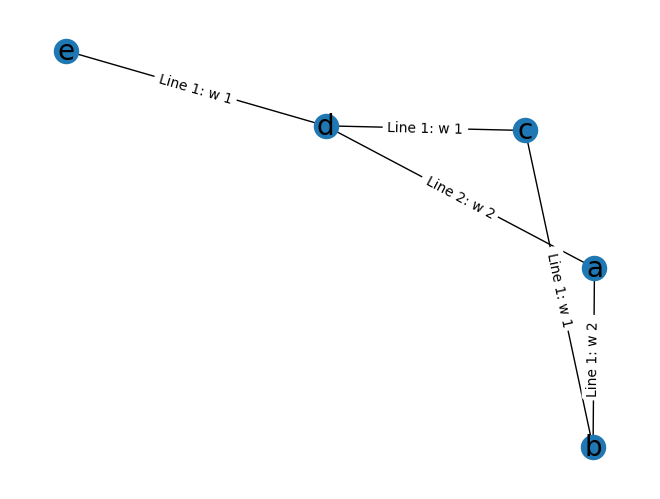

In [44]:
ex_graph = nx.Graph()

ex_graph.add_node('a')
ex_graph.add_node('b')
ex_graph.add_node('c')
ex_graph.add_node('d')
ex_graph.add_node('a')

ex_graph.add_edge('a', 'b', weight = 1, key='Line 1: w 2')
ex_graph.add_edge('b', 'c', weight = 1, key='Line 1: w 1')
ex_graph.add_edge('c', 'd', weight = 1, key='Line 1: w 1')
ex_graph.add_edge('a', 'd', weight = 1, key='Line 2: w 2')
ex_graph.add_edge('d', 'e', weight = 1, key='Line 1: w 1')

#code reference was nx documentation
p = nx.spring_layout(ex_graph)

nx.draw(ex_graph, p, with_labels=True, font_size= 20)
lab1 = nx.get_edge_attributes(ex_graph,'key')
lab2 = nx.get_edge_attributes(ex_graph,'weight')

_ = nx.draw_networkx_edge_labels( ex_graph, p, edge_labels= lab1)


If we add nodes to our explored list based solely on the station that is removed from the frontier, the fastest route will never be found. The cost of travel from a to d is 2, and the cost of travel from a to b to c is 3. d is explored before the path from station a to b to c to d can be added. The total path cost of a-d-e is 3+3 minutes of transition time while a-b-c-d-e is 5 minutes total.

This example shows that we can't maintain optimality of UCS with the new cost function if we don't consider all possible paths (including lines) to a station.

A simple adjustment could be made to definition of explored nodes to compensate for this. We no longer define an explored child based on the station that was opened, but the **path taken to the station that was opened**. This may be redundant because the algorithm will not reach a node in the exact same way more than once. This could lead to cases of infinite looping if no solution exists.

That stated UCS will prioritize exploring paths with lower total cost so the lack of a set of explored nodes to check against shouldn't impede the algorithms ability to find the optimal solution if it exists 

**With this considered, I will make the following changes to my UCS implimentation in 2.1**

In the prior implementation of UCS, I chose to improve the efficiency of the algorithm by **only considering the fastest line** that connects two stations when searching for solutions. In this case, we will need to add a record to the frontier for each edge connecting two nodes because the line of an edge is needed to compute future costs.

I will also remove the check for explored stations. As I mentioned the check for explored paths is redundant and check expanded stations leads to the potential for non optimal solutions. Because we expand nodes by cost, infinite looping will only occur if a solution doesn't exist. For this reason I added a cap to the number iterations that can occur in the while loop.

As far as I can tell there is no lookup table to determine average time between lines at each station. In theory you could add to this function so that it takes in the station and consults a lookup table to get a more accurate estimation for walk time between the prior line and next line.
For the sake of the assignment I approximate the time between any two lines as 2 minutes

**The cost function is defined as: cumulative time to the current node + (2 if the line to the child is different than the previous line, 0 otherwise)**

In [45]:
def updated_cost_function(prior_line, next_line,current_path_weight, weight_to_child):
    # if no transition, cost = current path cost + cost to child
    if prior_line == next_line:
        return current_path_weight + weight_to_child
    #if transition, cost = current path cost + cost to child + 2
    else:
        return current_path_weight + weight_to_child + 2

In [46]:
def ucs_cost_up(graph, initial, goal, print_exploration_cost=False, reverse=False):
    number_of_explored_nodes = 0
    frontier = PriorityQueue()
    #Same implimentation of frontier as UCS in 2.1
    #now the check to see if a 
    initial_record = [0, [(initial, '')]]
    
    frontier.put(initial_record)
    iterations = 0
    
    while frontier and iterations <10000:
        frontier_list = frontier.get()
        current_path = frontier_list[1].copy()
        current_node = frontier_list[1][-1][0]
        prior_line = frontier_list[1][-1][1]
        current_path_weight = frontier_list[0]
        number_of_explored_nodes += 1
        if current_node == goal:
            return path_to_child, number_of_explored_nodes, current_path_weight
    
        if reverse:
            neighbors = reversed(list(graph.neighbors(current_node)))
        else:
            neighbors = list(graph.neighbors(current_node))
            
        for child in neighbors:
            #As explained in the earlier text, we need to consider all paths to each node for UCS to remain optimal
            #iterate through each line that connects the current node to an unexplored child
            #we add a record to frontier for each edge that connects the child to the current node
            lines = graph.get_edge_data(current_node, child)
            for line in lines:
                weight_to_child = lines[line]['weight']
                path_to_child = current_path.copy()
                path_to_child.append((child,line))
                path_weight_to_child = updated_cost_function(prior_line, line, current_path_weight, weight_to_child)
                child_record = [path_weight_to_child, path_to_child]
                #No check for child 
                child_record = (path_weight_to_child, path_to_child )
                frontier.put(child_record)
                
    return None, None, None

In [47]:
def run_ucs_cost_up(start, end, reverse=False):
    solution, node_count, total_time_ucs = ucs_cost_up(tube_graph_multi, start, end, False, reverse)
    print('Path from start to end with station and line taken')
    print(solution)
    print('Average Time for Route: {}'.format(total_time_ucs))
    print('Number of Paths Considered: {}'.format(node_count))
    return solution

In [48]:
solution_ucs_cost_up = run_ucs_cost_up('Euston', 'Victoria')

Path from start to end with station and line taken
[('Euston', ''), ('Warren Street', 'Victoria'), ('Oxford Circus', 'Victoria'), ('Green Park', 'Victoria'), ('Oxford Circus', 'Victoria'), ('Green Park', 'Victoria')]
Average Time for Route: 9
Number of Paths Considered: 173


### Comparison

**Q: Using one of the routes mentioned above (or any route of your choice), give an example in your report of how this new cost has changed the paths returned by each algorithm. Explain which of the algorithms were not affected and why**

DFS and BFS do not use the cost function to order the nodes they traverse. Adjusting this will have no impact on the solutions provided by these algorithms because nodes are expanded based on the order they are discovered.

In the case of UCS, Canada Water to Stratford provides a good example for the output changes

In [49]:
solution_ucs = run_ucs('Canada Water', 'Stratford')

Path from start to end with station and line taken
['Canada Water', 'Rotherhithe', 'Wapping', 'Shadwell', 'Whitechapel', 'Stepney Green', 'Mile End', 'Stratford']
Average Time for Route: 14
Number of Nodes Visited: 52


In [50]:
solution_ucs_cost_up = run_ucs_cost_up('Canada Water', 'Stratford')

Path from start to end with station and line taken
[('Canada Water', ''), ('Canary Wharf', 'Jubilee'), ('North Greenwich', 'Jubilee'), ('Canning Town', 'Jubilee'), ('West Ham', 'Jubilee'), ('Canning Town', 'Jubilee'), ('West Ham', 'Jubilee')]
Average Time for Route: 17
Number of Paths Considered: 3950


## Hueristic Search

### Setup

**Q: Given that you know the zone(s) a station is in, consider how you might use this information to focus the search in the right direction and implement your heuristic Best-First Search (BFS) (Note: not Astar Search). Explain in the report the motivation for your heuristic and its formula, and illustrate its performance in terms of the average time taken as compared to the solution returned by UCS us- ing one of the routes mentioned above or any route of your choice (even if it does not work in practice).**

Best first search is a similar to uniform cost search, but instead of ordering our queue based on the cumulative cost to get to a child, we evaluate it solely on a heuristic. I will reuse the original implementation of UCS in 2.1 but adjust it to order records based on the heuristic function

For clarity, my goal was to produce an admissable heuristic (not required) and thought this could be a clever way to do it

### Methodology for the hueristic


Now, I return to the enhanced zone and minimum zone cost dictionaries.

The goal is to produce a dictionary that can look at the zone of a child and calculate the minimum cost to move from the child's zone to the zone of the solution. This would function as an admissible heuristic that prioritizes expanding children in zones that have lower minimum costs to travel to the zone where the end station is located.

To do this, I would like a dictionary that can look at the zone of the goal $z_g$ and the zone of the child $z_c$ and provide a minimum cost. The minimum time dictionary already provides this for a fair number of zones, but some pairs of zones are missing because there is no single edge that travels between them.

To approximate these values I will use the minimum travel time records that are already available 

In [51]:
print(min_time_dict)

{'5-4': 2, '4-5': 2, '4-4': 1, '4-3': 2, '3-4': 2, '3-3': 1, '3-2': 1, '2-3': 1, '2-2': 1, '2-1': 1, '1-2': 1, '1-1': 1, '6-5': 2, '5-6': 2, '5-5': 1, '4-6': 2, '6-4': 2, '6-6': 2, '2-4': 7, '4-2': 7, '6-a': 3, 'a-6': 3, 'a-a': 3, 'a-b': 4, 'b-a': 4, 'b-c': 4, 'c-b': 4, 'c-d': 8, 'd-c': 8, 'd-d': 4}


Funnily enough, we can treat these records as edges in a graph and use UCS to find the combination of existing steps between zones that minimizes the travel time from any pair of zones that does not already exist.

For example, say we want to compute the heuristic cost for a child in zone 1 when the goal is in zone 3. We have records in our data for 1-1, 1-2, 2-2, 2-3, 3-3

The edge 1-1 represents the minimum travel time from a station in zone 1 to zone 1. 1-2 represents minimum travel time from a station in zone 1 to a station in zone 2 etc.

We can guarantee the heuristic is admissible by treating the output as the combination of steps in our data that minimize the cost between these zones. We apply uniform cost search to find the optimal path of minimum cost zone transitions observed in the data.

In [52]:
zone_list = ['1','2','3','4','5','6','a', 'b', 'c','d']
min_zone_graph = nx.Graph()

for zone in zone_list:
    if not min_zone_graph.has_node(zone):
        min_zone_graph.add_node(zone)
    for key in min_time_dict: 
        if key[0] == zone:
            neighbor = key[2]
            min_time = min_time_dict[key]
            if not min_zone_graph.has_node(neighbor):
                min_zone_graph.add_node(neighbor)
            if not min_zone_graph.has_edge(zone, neighbor):
                min_zone_graph.add_edge(zone, neighbor, weight = min_time)

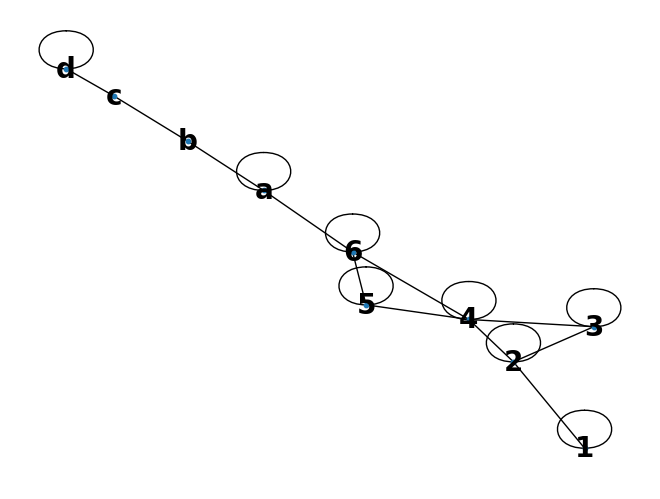

In [53]:
nx.draw(min_zone_graph, with_labels=True, node_size=10, font_weight='bold', font_size = 20)

In [54]:
def ucs_zone_min(graph, initial, goal):
    frontier = PriorityQueue()
    
    frontier.put((0, [initial]))
    explored = {initial}
    
    while frontier:
        frontier_tuple = frontier.get()
        current_path = frontier_tuple[1].copy()
        #index is to grab the station name from most recent item in the path
        current_node = current_path[-1]
        current_path_weight = frontier_tuple[0]
        explored.add(current_node)
       
        if current_node == goal:
            return current_path, current_path_weight
        
        neighbors = list(graph.neighbors(current_node))
            
        for child in neighbors:
            if child not in explored:
                weight = graph.get_edge_data(current_node, child)['weight']
                path_to_child = current_path.copy()
                path_to_child.append(child)
                path_weight_to_child = current_path_weight + weight
                frontier.put((path_weight_to_child, path_to_child ))
                
    return None

In [55]:
for i in zone_list:
    for j in zone_list:
        key = i+'-'+ j
        if key not in min_time_dict:
            _, min_time = ucs_zone_min(min_zone_graph, i, j)
            min_time_dict[key] = min_time
            

Final dictionary

In [56]:
print(min_time_dict)

{'5-4': 2, '4-5': 2, '4-4': 1, '4-3': 2, '3-4': 2, '3-3': 1, '3-2': 1, '2-3': 1, '2-2': 1, '2-1': 1, '1-2': 1, '1-1': 1, '6-5': 2, '5-6': 2, '5-5': 1, '4-6': 2, '6-4': 2, '6-6': 2, '2-4': 7, '4-2': 7, '6-a': 3, 'a-6': 3, 'a-a': 3, 'a-b': 4, 'b-a': 4, 'b-c': 4, 'c-b': 4, 'c-d': 8, 'd-c': 8, 'd-d': 4, '1-3': 2, '1-4': 4, '1-5': 6, '1-6': 6, '1-a': 9, '1-b': 13, '1-c': 17, '1-d': 25, '2-5': 5, '2-6': 5, '2-a': 8, '2-b': 12, '2-c': 16, '2-d': 24, '3-1': 2, '3-5': 4, '3-6': 4, '3-a': 7, '3-b': 11, '3-c': 15, '3-d': 23, '4-1': 4, '4-a': 5, '4-b': 9, '4-c': 13, '4-d': 21, '5-1': 6, '5-2': 5, '5-3': 4, '5-a': 5, '5-b': 9, '5-c': 13, '5-d': 21, '6-1': 6, '6-2': 5, '6-3': 4, '6-b': 7, '6-c': 11, '6-d': 19, 'a-1': 9, 'a-2': 8, 'a-3': 7, 'a-4': 5, 'a-5': 5, 'a-c': 8, 'a-d': 16, 'b-1': 13, 'b-2': 12, 'b-3': 11, 'b-4': 9, 'b-5': 9, 'b-6': 7, 'b-b': 0, 'b-d': 12, 'c-1': 17, 'c-2': 16, 'c-3': 15, 'c-4': 13, 'c-5': 13, 'c-6': 11, 'c-a': 8, 'c-c': 0, 'd-1': 25, 'd-2': 24, 'd-3': 23, 'd-4': 21, 'd-5': 21

### Implementation

In [57]:
def hueristic(node, exit):
    exit_zones = zone_dict_enh[exit]['main_zones']
    node_zones = zone_dict_enh[node]['main_zones']
    
    #child node is solution
    if node == exit:
        return 0

    min_times = []
    #iterate through all combinations of the zone of the node we are evaluating and the zone of the exit node
    #append the minimum times between theses combinations of zones to a list and return minimum
    for zone1 in exit_zones:
        for zone2 in node_zones:
            key = zone1 + '-' + zone2
            min_times.append(min_time_dict[key])
    return min(min_times)

In [58]:
#exact same implimentation as UCS in 2.1 besides replacement of the cost function with the hueristic 
#and the rearrangmenet of where the cumulative cost is stored
def best_first_search(graph, initial, goal, print_exploration_cost=False, reverse=False):
    number_of_explored_nodes = 0
    frontier = PriorityQueue()
    frontier.put((0, [(initial, 0 , '')]))
    explored = {initial}
    

    while frontier:
        frontier_tuple = frontier.get()
        current_path = frontier_tuple[1].copy()
        current_node = frontier_tuple[1][-1][0]
        #accesing the middle element (cumulative weight) of the most recent tuple appended to the current path
        #added cumulative weight to this tuple because it was tracked in the space that ranks priority queue in prior implimentation
        current_path_weight = frontier_tuple[1][-1][1] 
        explored.add(current_node)
        number_of_explored_nodes += 1
        
        if current_node == goal:
            if print_exploration_cost:
                print('UCS graph search explored {} nodes'.format(number_of_explored_nodes))
            return current_path, number_of_explored_nodes, current_path_weight
        
        if reverse:
            neighbors = reversed(list(graph.neighbors(current_node)))
        else:
            neighbors = list(graph.neighbors(current_node))
            
        for child in neighbors:
            if child not in explored:
                lines = graph.get_edge_data(current_node, child)
                edge_costs = []
                for line in lines:
                    weight = lines[line]['weight']
                    edge_costs.append((weight, line))
                fastest_line =  min(edge_costs)
                weight_to_child = fastest_line[0]
                path_to_child = current_path.copy()
                #cumulative weight of path is now calculated before appending record to list
                path_weight_to_child = current_path_weight + weight_to_child
                path_to_child.append((child, path_weight_to_child, line))
                hueristic_val = hueristic(child, goal)
                frontier.put((hueristic_val, path_to_child ))
                
    return None
   

In [59]:
def run_best_first_search(start, end, reverse=False):
    solution, node_count, total_time_bfs = best_first_search(tube_graph_multi, start, end, False, reverse)
    #remove path weights that were stored 
    for i in range(0,len(solution)):
        step = solution[i]
        solution[i] = (step[0], step[2])
    print('Path from start to end with station and line taken')
    print(solution)
    print('Average Time for Route: {}'.format(total_time_bfs))
    print('Number of Nodes Visited: {}'.format(node_count))
    return solution

### Comparison

The first comparison I did was from Canada Water to stratford. The algorithm returned a solution path that was 1 minute slower by only checking 13% of the nodes that UCS did to find the optimal solution. Zones are radial and in this case, the stations are located about on the same half of the circle. The huersitic encourages movement to zones that are close in minimum distance to the goal zone. It makes sense that the solution is directed around the circle and close/within zone 3.

In [60]:
print(zone_dict_enh['Canada Water'])
print(zone_dict_enh['Stratford'])

{'main_zones': {'2'}, 'connected_zones': {'2'}}
{'main_zones': {'3'}, 'connected_zones': {'3', '2'}}


In [61]:
solution_bfs = run_best_first_search('Canada Water','Stratford')

Path from start to end with station and line taken
[('Canada Water', ''), ('Canary Wharf', 'Jubilee'), ('North Greenwich', 'Jubilee'), ('Canning Town', 'Jubilee'), ('West Ham', 'Jubilee'), ('Stratford', 'Jubilee')]
Average Time for Route: 15
Number of Nodes Visited: 7


In [62]:
solution_ucs = run_ucs('Canada Water','Stratford', False, True)

Path from start to end with station and line taken
[('Canada Water', ''), ('Rotherhithe', 'East London'), ('Wapping', 'East London'), ('Shadwell', 'East London'), ('Whitechapel', 'East London'), ('Stepney Green', 'District'), ('Mile End', 'District'), ('Stratford', 'Central')]
Average Time for Route: 14
Number of Nodes Visited: 52


I checked another example to see the flaws of the heurstic. Euston to Victoria are both in zone 1. Best first search provides a solution with a cost significantly higher than UCS and only expands a slightly smaller number of nodes. I believe this has to do with the necessisity of zone 1. There is a high concentration of stations in this area and there is no way to discriminate between which path is better. 

In [63]:
print(zone_dict_enh['Euston'])
print(zone_dict_enh['Victoria'])

{'main_zones': {'1'}, 'connected_zones': {'1', '2'}}
{'main_zones': {'1'}, 'connected_zones': {'1'}}


In [64]:
solution_bfs = run_best_first_search('Euston','Victoria')

Path from start to end with station and line taken
[('Euston', ''), ("King's Cross St. Pancras", 'Victoria'), ('Angel', 'Northern'), ('Old Street', 'Northern'), ('Moorgate', 'Northern'), ('Bank/Monument', 'Northern'), ('Cannon Street', 'District'), ('Mansion House', 'District'), ('Blackfriars', 'District'), ('Temple', 'District'), ('Embankment', 'District'), ('Charing Cross', 'Northern'), ('Leicester Square', 'Northern'), ('Covent Garden', 'Piccadilly'), ('Holborn', 'Piccadilly'), ('Tottenham Court Road', 'Central'), ('Goodge Street', 'Northern'), ('Warren Street', 'Northern'), ('Oxford Circus', 'Victoria'), ('Bond Street', 'Central'), ('Baker Street', 'Jubilee'), ('Edgware Road', 'Hammersmith & City'), ('Paddington', 'Hammersmith & City'), ('Bayswater', 'District'), ('Notting Hill Gate', 'District'), ('High Street Kensington', 'District'), ("Earls' Court", 'District'), ('Gloucester Road', 'Piccadilly'), ('South Kensington', 'Piccadilly'), ('Knightsbridge', 'Piccadilly'), ('Hyde Park C

In [65]:
solution_ucs = run_ucs('Euston','Victoria')

Path from start to end with station and line taken
['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
Average Time for Route: 7
Number of Nodes Visited: 30


The heuristic struggles with solutions from east to west that traverse zone 1 as for the same reason. Overall I was still impressed by the ability of the huerstic considering it is still returns pratical paths in a fair number of solutions, and could be used with A* while preserving optimality

In [66]:
solution_bfs = run_best_first_search('Chiswick Park','Snaresbrook')

Path from start to end with station and line taken
[('Chiswick Park', ''), ('Acton Town', 'District'), ('Ealing Common', 'Piccadilly'), ('Ealing Broadway', 'District'), ('West Acton', 'Central'), ('North Acton', 'Central'), ('East Acton', 'Central'), ('White City', 'Central'), ("Shepherd's Bush", 'Central'), ('Goldhawk Road', 'Hammersmith & City'), ('Hammersmith', 'Hammersmith & City'), ('Barons Court', 'Piccadilly'), ("Earls' Court", 'Piccadilly'), ('Gloucester Road', 'Piccadilly'), ('High Street Kensington', 'Circle'), ('Notting Hill Gate', 'District'), ('Bayswater', 'District'), ('Paddington', 'District'), ('Edgware Road', 'Hammersmith & City'), ('Baker Street', 'Hammersmith & City'), ('Bond Street', 'Jubilee'), ('Green Park', 'Jubilee'), ('Hyde Park Corner', 'Piccadilly'), ('Knightsbridge', 'Piccadilly'), ('South Kensington', 'Piccadilly'), ('Sloane Square', 'District'), ('Victoria', 'District'), ("St. James' Park", 'District'), ('Westminster', 'District'), ('Embankment', 'District

In [67]:
solution_ucs = run_ucs('Chiswick Park','Snaresbrook')

Path from start to end with station and line taken
['Chiswick Park', 'Turnham Green', 'Hammersmith', 'Barons Court', "Earls' Court", 'Gloucester Road', 'South Kensington', 'Sloane Square', 'Victoria', "St. James' Park", 'Westminster', 'Waterloo', 'Bank/Monument', 'Liverpool Street', 'Bethnal Green', 'Mile End', 'Stratford', 'Leyton', 'Leytonstone', 'Snaresbrook']
Average Time for Route: 44
Number of Nodes Visited: 230


With Population size 100, mutation rate = .1, and crossover rate = .5

Mean number of iterations to finding solution is: 47.4
The standard deviation is 9.45

Note that this is not reproducible

In [81]:
import numpy as np

In [82]:
gens = []
for i in range(10):
    sol_gen = run_genetic()
    gens.append(sol_gen)
print('Mean Number of Iterations before Solution {}'.format(np.mean(gens)))
print('Std of Iterations before Solution {}'.format(np.std(gens)))

password for ec23800: MIYOANVCUO found in 32 generations
password for ec23800: MIYOANVCUO found in 44 generations
password for ec23800: MIYOANVCUO found in 44 generations
password for ec23800: MIYOANVCUO found in 39 generations
password for ec23800: MIYOANVCUO found in 31 generations
password for ec23800: MIYOANVCUO found in 40 generations
password for ec23800: MIYOANVCUO found in 43 generations
password for ec23800: MIYOANVCUO found in 45 generations
password for ec23800: MIYOANVCUO found in 50 generations
password for ec23800: MIYOANVCUO found in 31 generations
Mean Number of Iterations before Solution 39.9
Std of Iterations before Solution 6.268173577685928


I will compare how mutation and cross over rates impact the average

**The following two cells can take ~4 minutes to run** 

In [83]:
#calculating mutation rate for a number of values where cross over rate is equal to .5
#the genetic algorithm is run 10 times for each mutation rate
#if a solution is not found for any of the iterations, the converge column is false and the mean/std are Null
mut_rate = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
columns_mr = ['mut_rate','mean_gens','std_gens','converge','num_converge' ]
data_mr = []
for mr in mut_rate:
    print(mr)
    row = [mr]
    gens = []
    converge = True
    num_coverge = 10
    for i in range(10):
        sol_gen = run_genetic(p_mut=mr, p_rc = .5, print_result=False)
        gens.append(sol_gen)
        if sol_gen is None:
            converge = False
            num_coverge -= 1
    if converge:
        mean_gens = np.mean(gens)
        std_gens = np.std(gens)
        row.append(mean_gens)
        row.append(std_gens)
        row.append(converge)
        row.append(num_coverge)
        data_mr.append(row)
    else:
        row.append(None)
        row.append(None)
        row.append(converge)
        row.append(num_coverge)
        data_mr.append(row)

0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


In [84]:
#the same approach used in the prior cell but for crossover rate
#in this case mutation rate is held at .1
cross_rate = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
columns_cr = ['cross_rate','mean_gens','std_gens','converge', 'num_converge']
data_cr = []
for cr in cross_rate:
    print(cr)
    row = [cr]
    gens = []
    converge = True
    num_coverge = 10
    for i in range(10):
        sol_gen = run_genetic(p_mut=.1, p_rc = cr, print_result=False)
        gens.append(sol_gen)
        if sol_gen is None:
            converge = False
            num_coverge -= 1
    if converge:
        mean_gens = np.mean(gens)
        std_gens = np.std(gens)
        row.append(mean_gens)
        row.append(std_gens)
        row.append(converge)
        row.append(num_coverge)
        data_cr.append(row)
    else:
        row.append(None)
        row.append(None)
        row.append(converge)
        row.append(num_coverge)
        data_cr.append(row)

0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


In [85]:
summary_mr = pd.DataFrame(data = data_mr, columns = columns_mr)
summary_cr = pd.DataFrame(data = data_cr, columns = columns_cr)

As we can see when crossover rate is equal to .5, the algorithm does not find a solution in each of the 10 iterations when the mutation rate is 0, or the mutation rate is above a certain threshold

When the mutation rate is zero, the algorithm has no way to incorporate characters that are not in the intial population into the solution.

When the mutation rate is large, the amount of randomness introduced into a new population increases. This expands the number of solutions considered, but convergence can take much longer

In [86]:
summary_mr.head(11)

,mut_rate,mean_gens,std_gens,converge,num_converge
0,0.0,NaN,NaN,False,0
1,0.1,43.8,17.434449,True,10
2,0.2,45.1,17.958007,True,10
3,0.3,88.0,38.241339,True,10
4,0.4,NaN,NaN,False,9
5,0.5,NaN,NaN,False,6
6,0.6,NaN,NaN,False,1
7,0.7,NaN,NaN,False,0
8,0.8,NaN,NaN,False,0
9,0.9,NaN,NaN,False,0


It appears that in this case, the number of generations needed to find a solution increased as the mutation rate increased in the cases where all iterations of the algorithms found the solution

Text(0, 0.5, 'mean generations to solution')

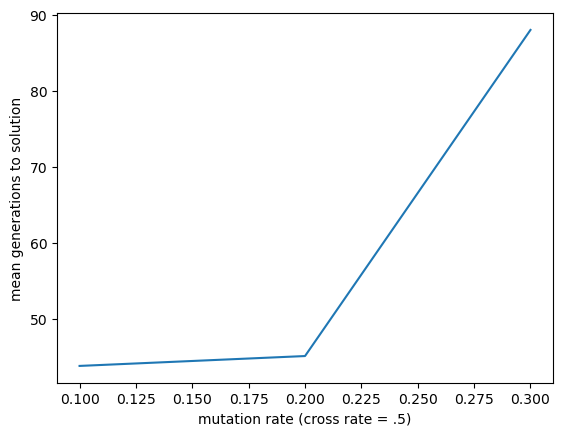

In [87]:
mr_converge = summary_mr[summary_mr['converge'] == True]
plt.plot(mr_converge['mut_rate'],mr_converge['mean_gens'] )
plt.xlabel('mutation rate (cross rate = .5)')
plt.ylabel('mean generations to solution')

It appears that as the mutation rate increases, the standard deviation of the number of the number of generations to find a solution increases. Again, as randomness introduced to our individuals increases, the range of time it takes to find a solution increases. Mutation introduces both bad and good solutions into the population.

Text(0, 0.5, 'std of generations to solution')

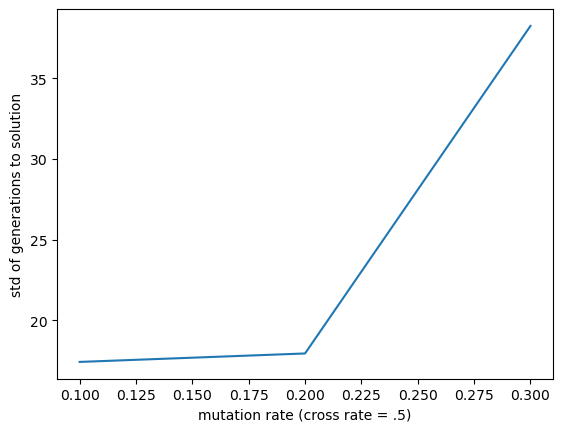

In [88]:
mr_converge = summary_mr[summary_mr['converge'] == True]
plt.plot(mr_converge['mut_rate'],mr_converge['std_gens'] )
plt.xlabel('mutation rate (cross rate = .5)')
plt.ylabel('std of generations to solution')

Of the values I tested for the crossover rate, the only times the algorithm did not find a solution in 400 generations was when no crossovers took place.

In this case, the only operator making changes to the population is the mutation operator. The algorithm is no longer recombining potential solutions so we are only making random changes to the solutions. This explains the lack of convergence

In [89]:
summary_cr.head(11)

,cross_rate,mean_gens,std_gens,converge,num_converge
0,0.0,NaN,NaN,False,3
1,0.1,111.1,30.713027,True,10
2,0.2,77.6,18.189008,True,10
3,0.3,59.1,15.782585,True,10
4,0.4,47.2,11.548160,True,10
5,0.5,48.7,14.464093,True,10
6,0.6,40.3,10.507616,True,10
7,0.7,44.4,14.284257,True,10
8,0.8,39.6,11.689311,True,10
9,0.9,30.2,8.897191,True,10


In this case it appears that the average number of generations needed to find a solution decreases as the crossover rate increases. As the crossover rate increases, a larger number of solutions is considered in selection. Its possible that the increased number of solutions leads to better options being picked at each generation, increasing the speed that a solution is found. Its also possible that it leads to the amplification of solutions with strong fitness. As cross over rate increases, a larger percentage of solutions will produce two children. If every strong solution is duplicated, varations of these solutions will make up a larger percentage of the population that is considered in the next generation

Text(0, 0.5, 'mean generations to solution')

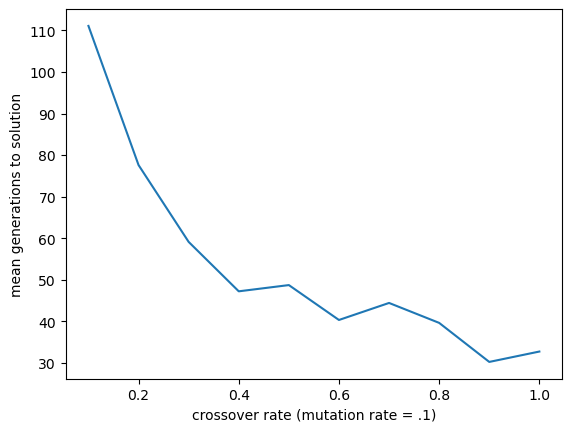

In [90]:
cr_converge = summary_cr[summary_cr['converge'] == True]
plt.plot(cr_converge['cross_rate'],cr_converge['mean_gens'] )
plt.xlabel('crossover rate (mutation rate = .1)')
plt.ylabel('mean generations to solution')

The standard deviation of the number of generations to find a solution appears to decrease as the crossover rate increases. The trend is not as clear as the one observed in the analysis of mutation rate, however this could be aproduct of the effect I explained previously. strong solutions are amplified through variations produced through recombination, leading to a more narrow focus of the population at earlier generations.

Text(0, 0.5, 'std of generations to solution')

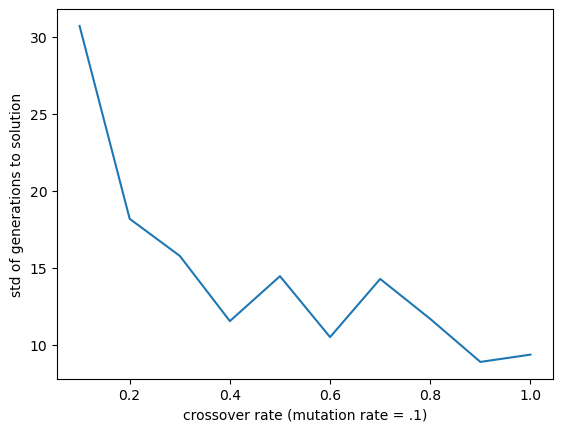

In [92]:
cr_converge = summary_cr[summary_cr['converge'] == True]
plt.plot(cr_converge['cross_rate'],cr_converge['std_gens'] )
plt.xlabel('crossover rate (mutation rate = .1)')
plt.ylabel('std of generations to solution')